# Clustering on Sales Data

**Problem Statement:** Implement K-Means clustering/ hierarchical clustering on `sales_data_sample.csv` dataset. Determine the number of clusters using the elbow method.

## 1. Import Libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 2. Load and Pre-process Data

In [35]:
# --- load ---
try:
    df = pd.read_csv("9_sales_data_sample.csv", encoding="unicode_escape")
    print("Data loaded successfully.")
    df.head()
except FileNotFoundError:
    print("Error: 'sales_data_sample.csv' not found.")
    print("Please download from: https://www.kaggle.com/datasets/kyanyoga/sample-sales-data")

Data loaded successfully.


In [36]:
# --- numeric features only (drop obvious non-numeric columns) ---
drop_if_present = [
    'OrderDate','OrderDateTime','Order ID','Address','ADDRESSLINE1',
    'ADDRESSLINE2','STATE','POSTALCODE','PHONE','CustomerID', 'CONTACTFIRSTNAME',
    'CONTACTLASTNAME', 'CUSTOMERNAME', 'CITY', 'COUNTRY', 'TERRITORY', 
    'PRODUCTLINE', 'PRODUCTCODE', 'DEALSIZE', 'STATUS'
]
df_clean = df.drop([c for c in drop_if_present if c in df.columns], axis=1, errors='ignore')

# Select only numeric columns for clustering
X = df_clean.select_dtypes(include=[np.number]).copy()
X = X.dropna(axis=1, how='all')  # drop empty numeric cols
X = X.fillna(X.median()) # Fill missing values with the median

print("Features selected for clustering:", X.columns.tolist())

Features selected for clustering: ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES', 'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'MSRP']


In [37]:
# --- scale ---
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
print("Data scaled.")

Data scaled.


## 3. Determine Optimal `k` (Elbow Method)

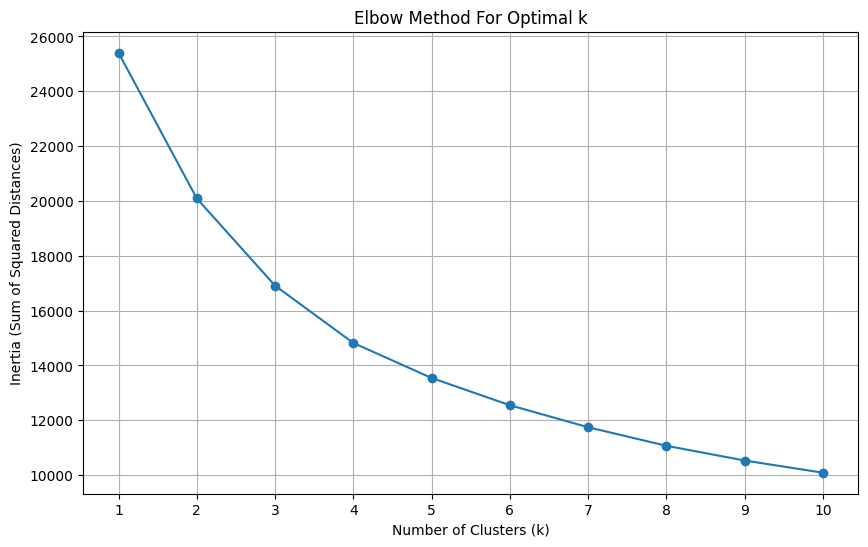

In [38]:
# --- elbow: inertia for k=1..10 ---
ks = list(range(1, 11))
inertias = []
for k in ks:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_test.fit(Xs)
    inertias.append(kmeans_test.inertia_)

# --- plot elbow ---
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(ks)
plt.grid(True)
plt.show()

### Automatic Elbow Detection

We can also programmatically find the 'elbow' by finding the point with the maximum distance from the line connecting the first (k=1) and last (k=10) inertia points.

In [39]:
# --- automatic elbow detection: distance from line (first-last) ---
# points (k, inertia)
pts = np.column_stack((ks, inertias))
p1, p2 = pts[0], pts[-1]
# line vector
v = p2 - p1
# distances
distances = np.abs(np.cross(v, pts - p1) / np.linalg.norm(v))
optimal_k = int(ks[np.argmax(distances)])
if optimal_k < 2:
    optimal_k = 2 # Ensure k is at least 2

print("Inertia by k:", dict(zip(ks, [round(i, 2) for i in inertias])))
print("\nDetected elbow (optimal k):", optimal_k)

Inertia by k: {1: 25407.0, 2: 20090.89, 3: 16909.33, 4: 14818.01, 5: 13541.41, 6: 12547.11, 7: 11743.69, 8: 11067.29, 9: 10529.86, 10: 10085.26}

Detected elbow (optimal k): 4


## 4. Model Training

Using the `optimal_k` found above.

In [40]:
# --- final KMeans ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(Xs)
df['kmeans_cluster'] = kmeans.labels_

print(f"KMeans model trained with k={optimal_k}")

KMeans model trained with k=4


In [41]:
# --- hierarchical clustering (Agglomerative) ---
agg = AgglomerativeClustering(n_clusters=optimal_k).fit(Xs)
df['hier_cluster'] = agg.labels_

print(f"Hierarchical model trained with n_clusters={optimal_k}")

Hierarchical model trained with n_clusters=4


## 5. View Results

In [42]:
# --- outputs ---
print("\nKMeans cluster counts:")
print(df['kmeans_cluster'].value_counts().sort_index().to_dict())

print("\nHierarchical cluster counts:")
print(df['hier_cluster'].value_counts().sort_index().to_dict())


KMeans cluster counts:
{0: 478, 1: 948, 2: 663, 3: 734}

Hierarchical cluster counts:
{0: 1094, 1: 690, 2: 478, 3: 561}


In [43]:
# compact cluster summary (means of numeric features)
print("\nKMeans cluster centers (in original scale):")
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns).round(3)
print(centers_df)


KMeans cluster centers (in original scale):
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER     SALES  QTR_ID  \
0    10392.297           36.885     83.445            5.973  3747.880   1.368   
1    10251.919           35.880     98.117            6.524  4667.526   3.629   
2    10181.014           34.884     85.941            6.423  3467.217   1.485   
3    10250.628           33.097     63.045            6.752  2065.889   3.530   

   MONTH_ID   YEAR_ID     MSRP  
0     3.002  2005.000  100.167  
1     9.831  2003.567  127.541  
2     3.364  2003.565  100.665  
3     9.578  2003.590   66.436  


In [44]:
# # save labelled data if needed
# df.to_csv("sales_clusters_labeled.csv", index=False)
# print("\nSaved labeled data to sales_clusters_labeled.csv")